In [1]:
# Color-Based Climbing Hold Segmentation
# This notebook demonstrates basic color segmentation for climbing holds

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import os

# Set up matplotlib for better display in Jupyter
plt.rcParams['figure.figsize'] = (12, 8)

def load_and_display_image(image_path):
    """Load an image and display it"""
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not load image from {image_path}")
        return None
    
    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display original image
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title('Original Climbing Wall Image')
    plt.axis('off')
    plt.show()
    
    return img, img_rgb

def extract_dominant_colors(image, k=8):
    """Extract dominant colors from the image using K-means clustering"""
    # Reshape image to be a list of pixels
    data = image.reshape((-1, 3))
    data = np.float32(data)
    
    # Apply K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert back to uint8 and get the color palette
    centers = np.uint8(centers)
    
    # Count the frequency of each cluster
    label_counts = Counter(labels.flatten())
    
    # Create color palette visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Show original image
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Show color palette
    palette_height = 100
    palette_width = 50
    palette = np.zeros((palette_height, palette_width * k, 3), dtype=np.uint8)
    
    for i, center in enumerate(centers):
        palette[:, i*palette_width:(i+1)*palette_width] = center
    
    ax2.imshow(palette)
    ax2.set_title(f'Dominant Colors (K={k})')
    ax2.axis('off')
    
    # Add color values as text
    for i, (center, count) in enumerate(zip(centers, [label_counts[i] for i in range(k)])):
        percentage = (count / len(labels)) * 100
        ax2.text(i*palette_width + palette_width//2, palette_height//2, 
                f'RGB: {center}\n{percentage:.1f}%', 
                ha='center', va='center', fontsize=8, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return centers, labels.reshape(image.shape[:2])

def create_color_mask(image, target_color, tolerance=50):
    """Create a mask for a specific color with tolerance"""
    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    target_hsv = cv2.cvtColor(np.uint8([[target_color]]), cv2.COLOR_RGB2HSV)[0][0]
    
    # Convert values to int to avoid overflow warnings
    h, s, v = int(target_hsv[0]), int(target_hsv[1]), int(target_hsv[2])
    
    # Handle red color wrap-around in HSV (red is at 0 and 180)
    if target_color[0] > 200 and target_color[1] < 100 and target_color[2] < 100:  # Pure red detection
        # Red wraps around in HSV, so we need two ranges
        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 50, 50])
        upper_red2 = np.array([179, 255, 255])
        
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask1, mask2)
    else:
        # For other colors, use normal range
        lower_bound = np.array([max(0, target_hsv[0] - tolerance//3), 50, 50])
        upper_bound = np.array([min(179, target_hsv[0] + tolerance//3), 255, 255])
        
        mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    return mask

def segment_holds_by_color(image, target_colors, tolerance=50):
    """Segment climbing holds by specific colors"""
    fig, axes = plt.subplots(2, len(target_colors), figsize=(4*len(target_colors), 8))
    if len(target_colors) == 1:
        axes = axes.reshape(2, 1)
    
    masks = []
    
    for i, color in enumerate(target_colors):
        # Create mask for this color
        mask = create_color_mask(image, color, tolerance)
        
        # Apply morphological operations to clean up the mask
        kernel = np.ones((5,5), np.uint8)
        mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)
        
        # Apply mask to original image
        segmented = image.copy()
        segmented[mask_cleaned == 0] = [0, 0, 0]  # Make non-target areas black
        
        # Display results
        axes[0, i].imshow(mask_cleaned, cmap='gray')
        axes[0, i].set_title(f'Mask for Color {i+1}\nRGB: {color}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(segmented)
        axes[1, i].set_title(f'Segmented Holds')
        axes[1, i].axis('off')
        
        masks.append(mask_cleaned)
    
    plt.tight_layout()
    plt.show()
    
    return masks

def detect_hold_contours(mask, min_area=500):
    """Detect individual holds from a color mask"""
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area
    valid_contours = [c for c in contours if cv2.contourArea(c) > min_area]
    
    return valid_contours

def visualize_detected_holds(image, masks, colors, min_area=500):
    """Visualize detected holds with bounding boxes"""
    result = image.copy()
    
    all_holds_info = []
    
    for i, (mask, color) in enumerate(zip(masks, colors)):
        contours = detect_hold_contours(mask, min_area)
        
        for j, contour in enumerate(contours):
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)
            
            # Draw bounding box
            cv2.rectangle(result, (x, y), (x+w, y+h), color[::-1], 3)  # BGR format for cv2
            
            # Add label
            cv2.putText(result, f'Hold_{i+1}_{j+1}', (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color[::-1], 2)
            
            # Store hold information
            hold_info = {
                'color_group': i+1,
                'hold_id': j+1,
                'bbox': (x, y, w, h),
                'area': cv2.contourArea(contour),
                'center': (x + w//2, y + h//2)
            }
            all_holds_info.append(hold_info)
    
    # Display result
    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.title(f'Detected Holds (Total: {len(all_holds_info)})')
    plt.axis('off')
    plt.show()
    
    return all_holds_info

# Example usage and testing functions
def quick_test_with_sample_colors():
    """Quick test with common climbing hold colors"""
    # Common climbing hold colors (RGB values)
    test_colors = [
        [220, 20, 20],   # Darker red (pure red often doesn't work well)
        [0, 255, 0],   # Green  
        [0, 0, 255],   # Blue
        [255, 255, 0],  # Yellow
        [255, 0, 255],  # Magenta/Purple
        [0, 255, 255],  # Cyan
    ]
    
    print("Common climbing hold colors to look for:")
    for i, color in enumerate(test_colors):
        print(f"Color {i+1}: RGB{color}")
    
    return test_colors

def debug_color_detection(image, target_color, tolerance_range=[30, 50, 70, 90]):
    """Debug function to test different tolerance values for a specific color"""
    print(f"Testing color detection for RGB: {target_color}")
    
    fig, axes = plt.subplots(2, len(tolerance_range), figsize=(4*len(tolerance_range), 8))
    
    for i, tol in enumerate(tolerance_range):
        mask = create_color_mask(image, target_color, tol)
        
        # Apply mask to original image
        segmented = image.copy()
        segmented[mask == 0] = [0, 0, 0]
        
        axes[0, i].imshow(mask, cmap='gray')
        axes[0, i].set_title(f'Mask (tolerance={tol})')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(segmented)
        axes[1, i].set_title(f'Segmented (tolerance={tol})')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def interactive_color_picker(image):
    """Interactive function to help pick colors from the image"""
    print("=== Interactive Color Picker ===")
    print("This will help you find the exact RGB values of holds in your image")
    
    # Show image with grid for easier coordinate picking
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)
    ax.set_title('Click on holds to get their RGB values\n(Note: This is just for visualization - use print statements below)')
    ax.grid(True, alpha=0.3)
    
    # Add instructions for manual color picking
    height, width = image.shape[:2]
    
    print("\nTo manually pick colors:")
    print("1. Look at the image above")
    print("2. Estimate coordinates of a hold you want to detect")
    print("3. Use the function below to get RGB values:")
    print("\n# Example usage:")
    print("# get_pixel_color(image, x=100, y=200)  # Replace with actual coordinates")
    
    plt.show()
    
    return image

def get_pixel_color(image, x, y):
    """Get RGB color at specific pixel coordinates"""
    if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]:
        color = image[y, x]  # Note: image indexing is [row, col] = [y, x]
        print(f"RGB color at ({x}, {y}): {color}")
        return color.tolist()
    else:
        print(f"Coordinates ({x}, {y}) are outside image bounds")
        return None

# Main workflow function
def analyze_climbing_wall(image_path, target_colors=None, tolerance=50, min_hold_area=500):
    """Complete workflow for analyzing a climbing wall image"""
    
    print("=== Climbing Wall Analysis ===")
    
    # Step 1: Load image
    print("1. Loading image...")
    img, img_rgb = load_and_display_image(image_path)
    if img is None:
        return
    
    # Step 2: Extract dominant colors if no target colors specified
    if target_colors is None:
        print("2. Extracting dominant colors...")
        dominant_colors, color_labels = extract_dominant_colors(img_rgb, k=8)
        print("Choose colors from the palette above for hold segmentation")
        target_colors = quick_test_with_sample_colors()
    
    # Step 3: Segment holds by color
    print("3. Segmenting holds by color...")
    masks = segment_holds_by_color(img_rgb, target_colors, tolerance)
    
    # Step 4: Detect individual holds
    print("4. Detecting individual holds...")
    holds_info = visualize_detected_holds(img_rgb, masks, target_colors, min_hold_area)
    
    print(f"\n=== Results ===")
    print(f"Total holds detected: {len(holds_info)}")
    for hold in holds_info:
        print(f"Color Group {hold['color_group']}, Hold {hold['hold_id']}: "
              f"Center at {hold['center']}, Area: {hold['area']:.0f} pixels")
    
    return holds_info

=== Climbing Wall Analysis ===
1. Loading image...


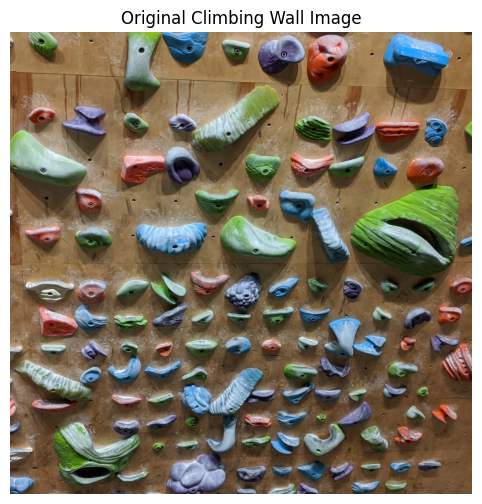

2. Extracting dominant colors...


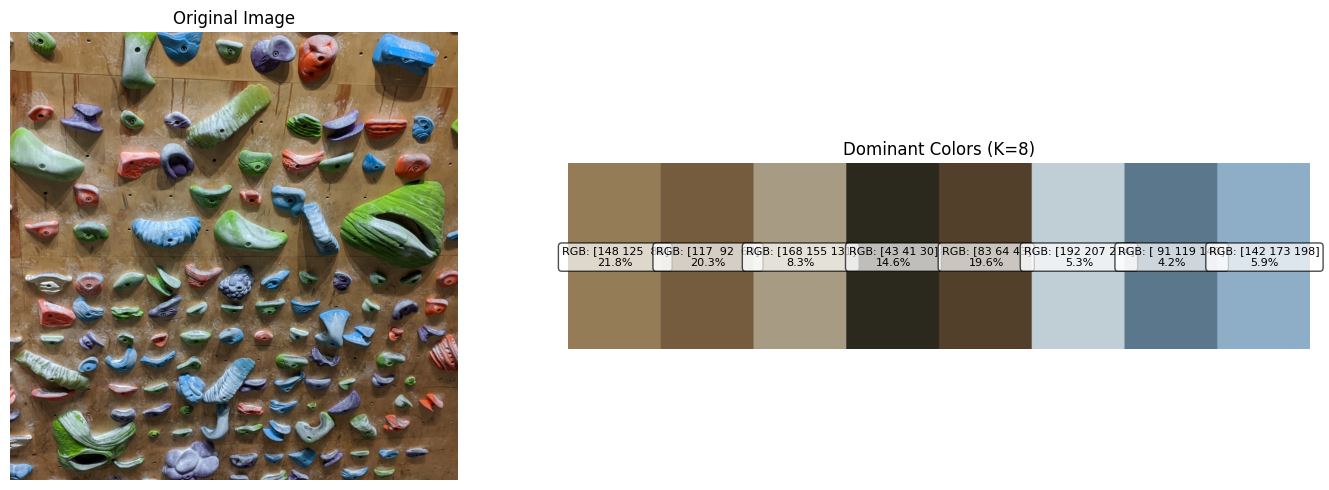

Choose colors from the palette above for hold segmentation
Common climbing hold colors to look for:
Color 1: RGB[220, 20, 20]
Color 2: RGB[0, 255, 0]
Color 3: RGB[0, 0, 255]
Color 4: RGB[255, 255, 0]
Color 5: RGB[255, 0, 255]
Color 6: RGB[0, 255, 255]
3. Segmenting holds by color...


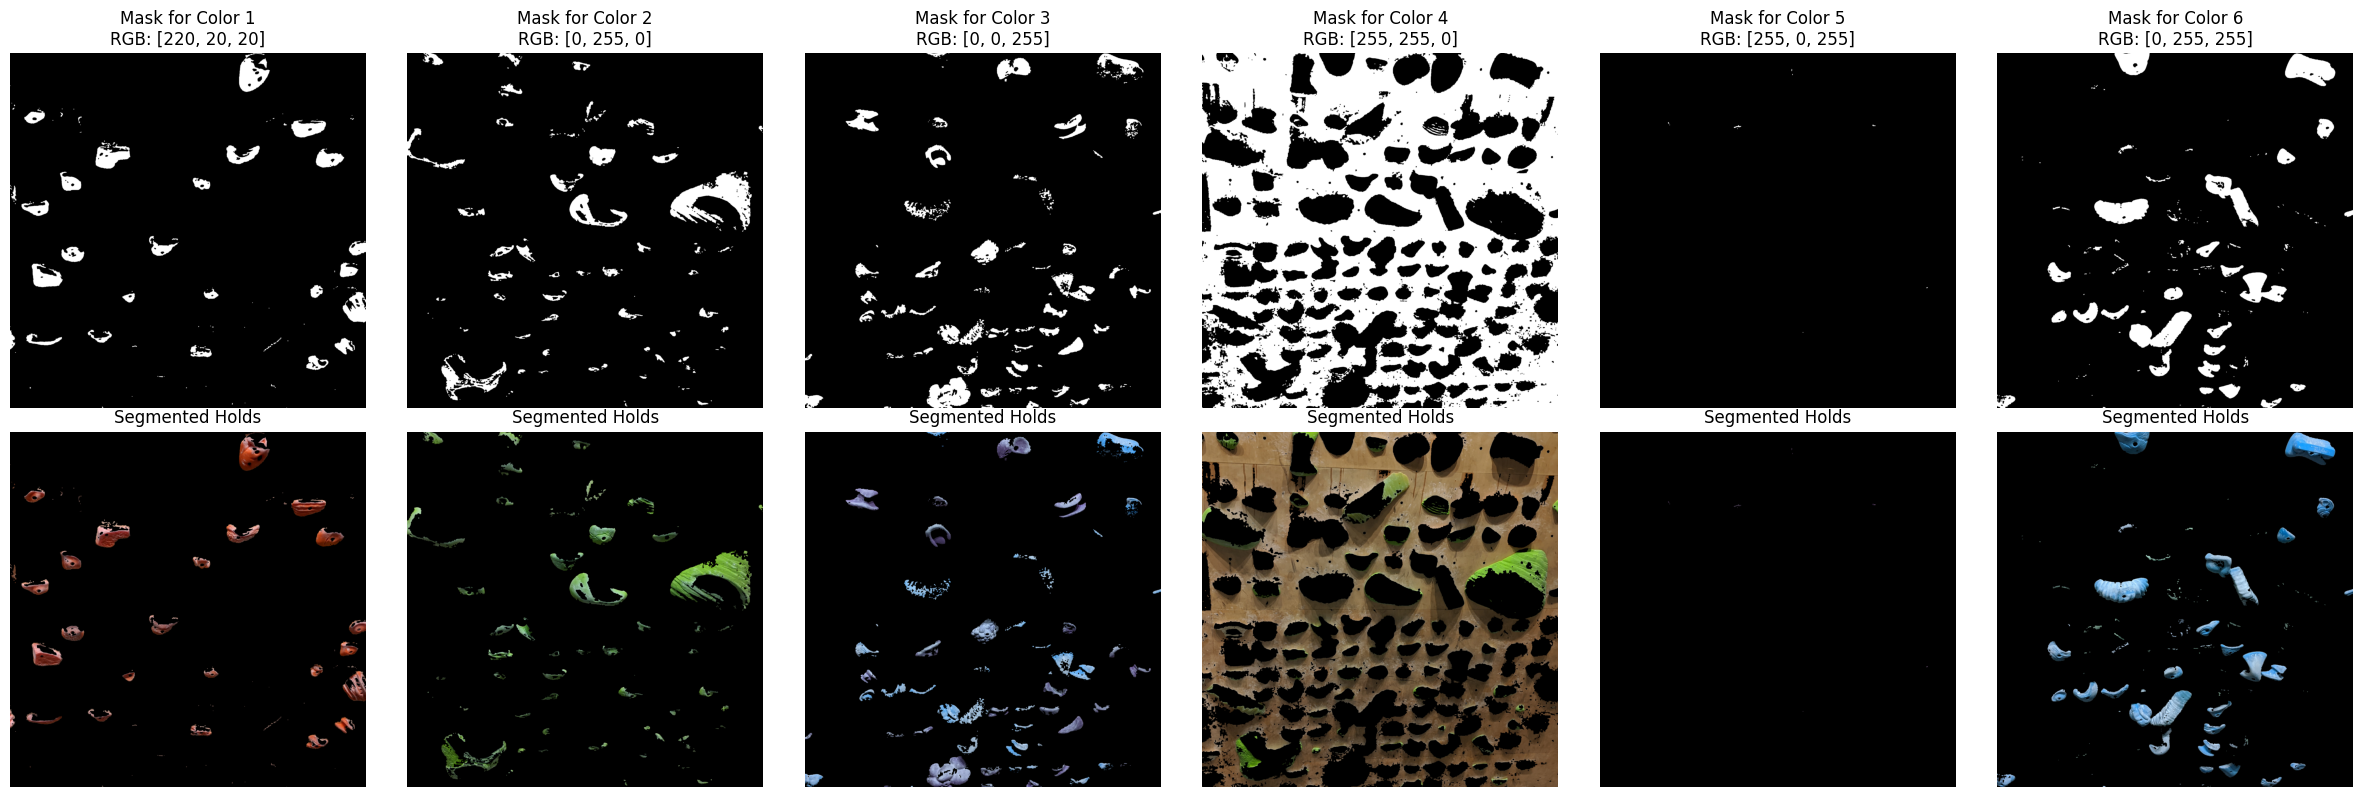

4. Detecting individual holds...


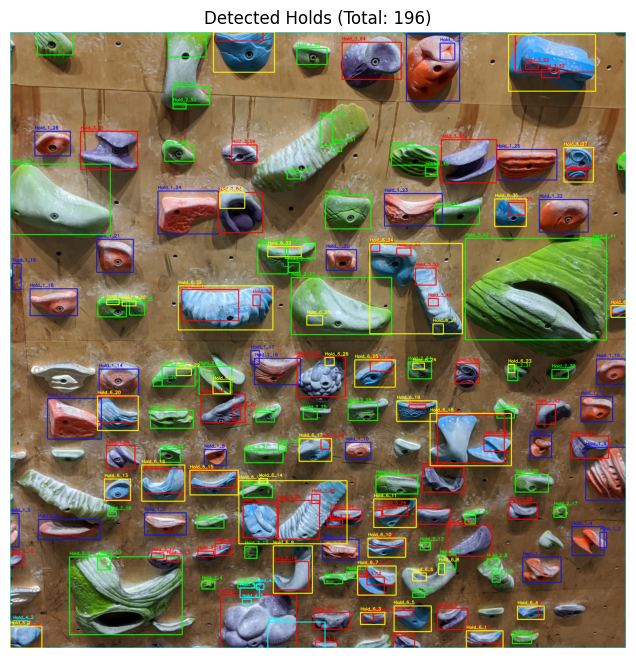


=== Results ===
Total holds detected: 196
Color Group 1, Hold 1: Center at (2611, 2639), Area: 12206 pixels
Color Group 1, Hold 2: Center at (1622, 2541), Area: 8644 pixels
Color Group 1, Hold 3: Center at (2912, 2493), Area: 606 pixels
Color Group 1, Hold 4: Center at (2837, 2498), Area: 10935 pixels
Color Group 1, Hold 5: Center at (289, 2441), Area: 9678 pixels
Color Group 1, Hold 6: Center at (22, 2445), Area: 4114 pixels
Color Group 1, Hold 7: Center at (762, 2414), Area: 6920 pixels
Color Group 1, Hold 8: Center at (1007, 2088), Area: 5327 pixels
Color Group 1, Hold 9: Center at (2925, 2168), Area: 31803 pixels
Color Group 1, Hold 10: Center at (1708, 2055), Area: 5708 pixels
Color Group 1, Hold 11: Center at (2605, 2034), Area: 7689 pixels
Color Group 1, Hold 12: Center at (316, 1898), Area: 30718 pixels
Color Group 1, Hold 13: Center at (2880, 1851), Area: 12067 pixels
Color Group 1, Hold 14: Center at (534, 1719), Area: 17530 pixels
Color Group 1, Hold 15: Center at (2951, 16

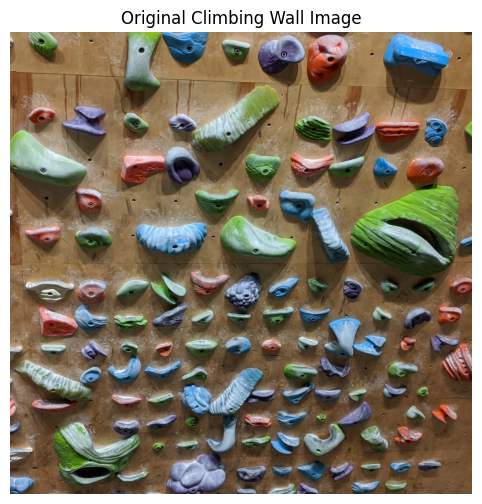

3. Segmenting holds by color...


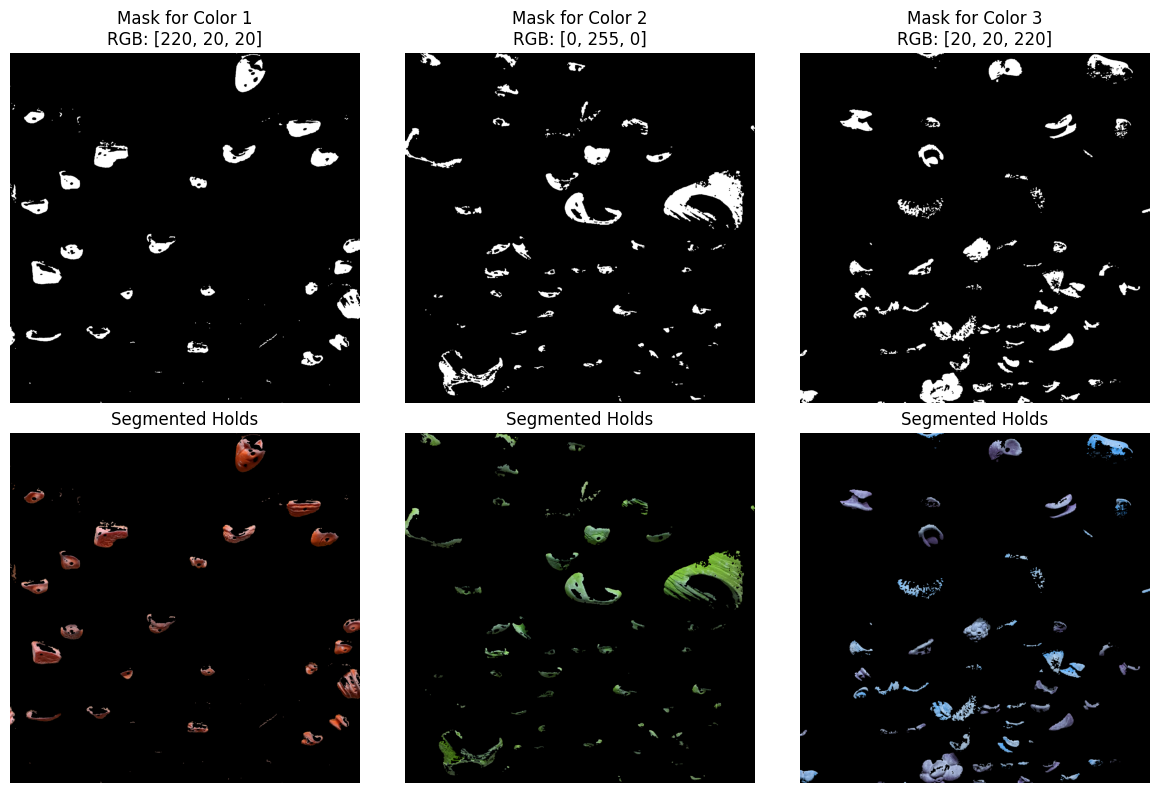

4. Detecting individual holds...


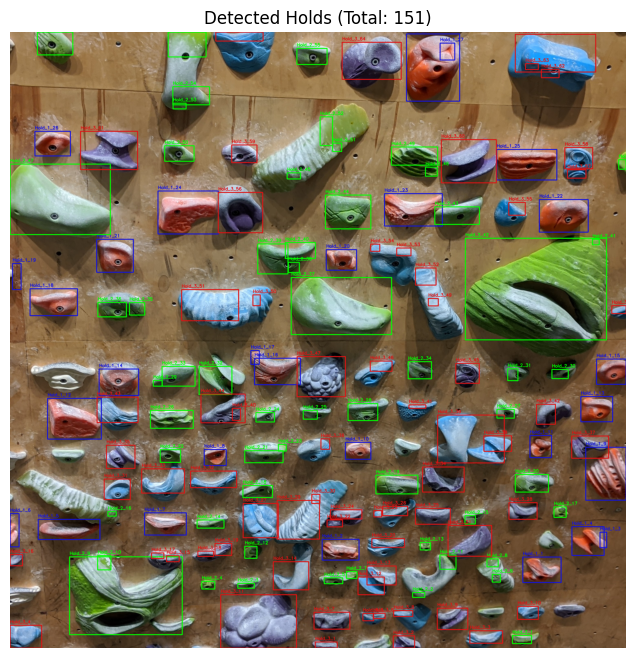


=== Results ===
Total holds detected: 151
Color Group 1, Hold 1: Center at (2611, 2639), Area: 12206 pixels
Color Group 1, Hold 2: Center at (1622, 2541), Area: 8644 pixels
Color Group 1, Hold 3: Center at (2912, 2493), Area: 606 pixels
Color Group 1, Hold 4: Center at (2837, 2498), Area: 10935 pixels
Color Group 1, Hold 5: Center at (289, 2441), Area: 9678 pixels
Color Group 1, Hold 6: Center at (22, 2445), Area: 4114 pixels
Color Group 1, Hold 7: Center at (762, 2414), Area: 6920 pixels
Color Group 1, Hold 8: Center at (1007, 2088), Area: 5327 pixels
Color Group 1, Hold 9: Center at (2925, 2168), Area: 31803 pixels
Color Group 1, Hold 10: Center at (1708, 2055), Area: 5708 pixels
Color Group 1, Hold 11: Center at (2605, 2034), Area: 7689 pixels
Color Group 1, Hold 12: Center at (316, 1898), Area: 30718 pixels
Color Group 1, Hold 13: Center at (2880, 1851), Area: 12067 pixels
Color Group 1, Hold 14: Center at (534, 1719), Area: 17530 pixels
Color Group 1, Hold 15: Center at (2951, 16

In [2]:
holds_info = analyze_climbing_wall('C:/Users/0fore/Downloads/test_wall.jpg')
custom_colors = [[220, 20, 20], [0, 255, 0], [20, 20, 220]]
holds_info = analyze_climbing_wall('test_wall.jpg', target_colors=custom_colors)